# Appendix I - Model Code
## 1. RandomForest

In [1]:
# import package to process data and machine learning
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
# read data from file
df = pd.read_excel('LendingClubData_training.xlsx')
df_test_original = pd.read_excel('LendingClubData_testing.xlsx')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,35000,35000,34975.0,60 months,0.1171,773.44,B,B3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,NaN,NaN,9500,9500,9500.0,36 months,0.1465,327.70,C,C3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,NaN,NaN,3800,3800,3800.0,36 months,0.0751,118.23,A,A3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,NaN,NaN,12400,12400,12400.0,60 months,0.2206,342.90,F,F4,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,NaN,NaN,4000,4000,4000.0,60 months,0.1727,100.00,D,D3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


In [3]:
# according to data analysis to determine useful features
useful_columns = ['loan_amnt', 'sub_grade', 'term', 'home_ownership', 'annual_inc',
                  'verification_status', 'dti', 'open_acc', 'inq_last_6mths', 'purpose',
                  'revol_util', 'loan_status']
parameters = ['loan_amnt', 'sub_grade', 'term', 'home_ownership','annual_inc', 'purpose', 'revol_util',
                  'verification_status', 'dti', 'open_acc', 'inq_last_6mths']

In [4]:
# drop missing data, low proportion
df_train = df[useful_columns]
df_train.dropna(inplace=True)

/Users/zhangyibin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# drop features which are not in test data set
df_train = df_train[~df_train['purpose'].str.contains('educational')]
df_train = df_train[~df_train['home_ownership'].str.contains('NONE')]
df_train = df_train[~df_train['home_ownership'].str.contains('OTHER')]

In [6]:
df_train.head()

,loan_amnt,sub_grade,term,home_ownership,annual_inc,verification_status,dti,open_acc,inq_last_6mths,purpose,revol_util,loan_status
0,35000,B3,60 months,MORTGAGE,110000.0,Verified,1.06,10,0,small_business,0.064,Charged Off
1,9500,C3,36 months,RENT,54000.0,Verified,17.69,6,1,other,0.853,Fully Paid
2,3800,A3,36 months,MORTGAGE,47000.0,Source Verified,22.52,10,3,car,0.393,Charged Off
3,12400,F4,60 months,OWN,65004.0,Source Verified,6.26,11,3,debt_consolidation,0.775,Charged Off
4,4000,D3,60 months,RENT,45000.0,Source Verified,7.37,10,0,other,0.825,Charged Off


In [7]:
# change targe value into (0, 1)
dic = {'Charged Off':0, 'Fully Paid': 1}
df_train['loan_status'].replace(dic, inplace=True)

In [8]:
# one-hot encoding transform categorical parameters into vectors, normalize numerical parameters
X_original_train = pd.get_dummies(df_train[parameters])

loan_amnt_max = X_original_train['loan_amnt'].max()
loan_amnt_min = X_original_train['loan_amnt'].min()

annul_inc_max = X_original_train['annual_inc'].max()
annul_inc_min = X_original_train['annual_inc'].min()

X_original_train['loan_amnt'] = (X_original_train['loan_amnt'] - loan_amnt_min)/(loan_amnt_max - loan_amnt_min)
X_original_train['annual_inc'] = (X_original_train['annual_inc'] - annul_inc_min)/(annul_inc_max - annul_inc_min)
Y_original_train = df_train['loan_status']

In [9]:
X_original_train.head()

,loan_amnt,annual_inc,revol_util,dti,open_acc,inq_last_6mths,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,1.000000,0.017665,0.064,1.06,10,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.260870,0.008326,0.853,17.69,6,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0.095652,0.007158,0.393,22.52,10,3,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0.344928,0.010161,0.775,6.26,11,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.101449,0.006825,0.825,7.37,10,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [10]:
# same data process to test data set, 
# using pad method to fill null value of only one missing value in revol_util feature
df_test = df_test_original[useful_columns]
df_test = df_test[useful_columns].fillna(method='pad')
y_test = df_test['loan_status'].replace(dic)
X_test = pd.get_dummies(df_test[parameters])
X_test['loan_amnt'] = (X_test['loan_amnt'] - loan_amnt_min)/(loan_amnt_max - loan_amnt_min)
X_test['annual_inc'] = (X_test['annual_inc'] - annul_inc_min)/(annul_inc_max - annul_inc_min)

In [11]:
# import Random Forest classifier
# import three resample process methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours
ros = RandomOverSampler(random_state=0)
sms = SMOTE()
ads = ADASYN()
rus = RandomUnderSampler()
nms = NearMiss(version=1)
enns = EditedNearestNeighbours()

In [12]:
# default training and acurracy result
rf0 = RandomForestClassifier(random_state=10)
rf0.fit(X_original_train, Y_original_train)
rf0.score(X_test, y_test)

0.8273001508295625

In [13]:
# default training and AUC-ROC result
y_pred = rf0.predict(X_test)
metrics.roc_auc_score(y_test, y_pred)

0.5069371713208486

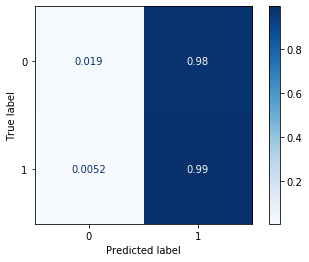

In [14]:
# confusion matrix display
disp = plot_confusion_matrix(rf0, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

<Figure size 432x288 with 0 Axes>

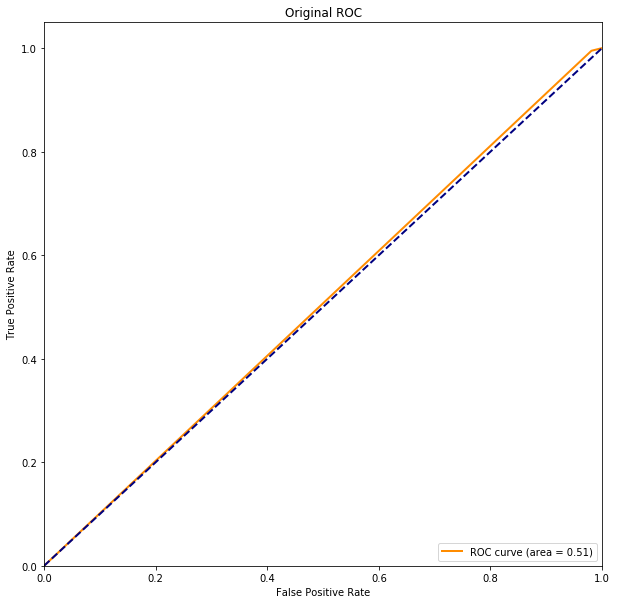

In [15]:
# AUC-ROC curve display
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Original ROC')
plt.legend(loc="lower right")
plt.show()

## 2. Over Resample and Under Resample

In [16]:
# prototype function for each resample method
def resample_result(model, x, y, x_test, y_test):
    X_train, y_train = model.fit_resample(x, y)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train)
    rf = RandomForestClassifier(random_state=10)
    rf.fit(Xtrain, ytrain)
    print("Accuracy: ", rf.score(x_test, y_test))
    y_pred = rf.predict(X_test)
    print("Roc_auc: ", metrics.roc_auc_score(y_test, y_pred))
    disp = plot_confusion_matrix(rf, x_test, y_test, cmap=plt.cm.Blues, normalize='true')

Accuracy:  0.8109602815485168
Roc_auc:  0.5452402482131629


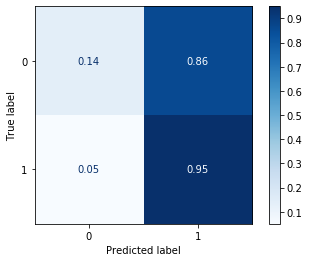

In [17]:
# Random Over Sampling
resample_result(ros, X_original_train, Y_original_train, X_test, y_test)

Accuracy:  0.8086978381096028
Roc_auc:  0.5363303910046057


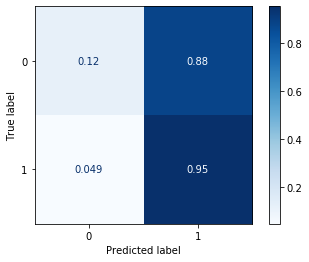

In [18]:
# SMOTE
resample_result(sms, X_original_train, Y_original_train, X_test, y_test)

Accuracy:  0.8137254901960784
Roc_auc:  0.5382046536635436


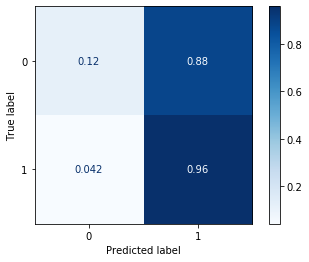

In [19]:
# ADASYN
resample_result(ads, X_original_train, Y_original_train, X_test, y_test)

Accuracy:  0.5824534942182001
Roc_auc:  0.6185402257735555


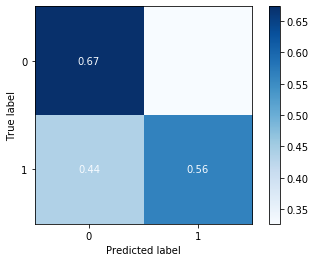

In [20]:
# Random Under Sampling
resample_result(rus, X_original_train, Y_original_train, X_test, y_test)

Accuracy:  0.4034690799396682
Roc_auc:  0.5354514693499401


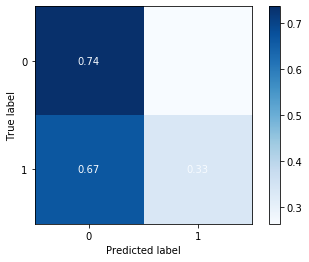

In [21]:
# NearMiss-1
resample_result(nms, X_original_train, Y_original_train, X_test, y_test)

Accuracy:  0.8051784816490699
Roc_auc:  0.5585793728907325


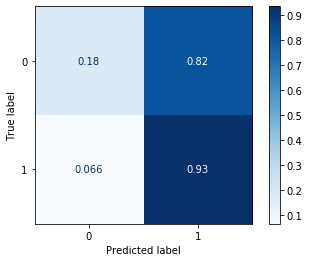

In [22]:
# Edited Nearest Neighbors
resample_result(enns, X_original_train, Y_original_train, X_test, y_test)

## 3.1 Random Over Sample

In [23]:
# using Grid Search Method to tuning parameters
# random selection part of training data to tuning
from sklearn.model_selection import GridSearchCV
X_train, y_train = ros.fit_resample(X_original_train, Y_original_train)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train)

In [24]:
# tuning n_estimators
param_test1 = {'n_estimators': range(10, 71, 10)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(min_samples_split=100,
                                                        min_samples_leaf=20,
                                                        max_depth=8,
                                                        max_features='sqrt',
                                                        random_state=10),
                       param_grid=param_test1, scoring='roc_auc', cv=5, n_jobs=4)
gsearch1.fit(Xtrain, ytrain)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.7049828745164634)

In [28]:
# tuning max_depth
param_test2 = {'max_depth':range(3, 14, 2), 'min_samples_split':range(50, 201, 20)}
gsearch2 = GridSearchCV(estimator=RandomForestClassifier(n_estimators=70,
                                                        min_samples_leaf=20,
                                                        max_features='sqrt',
                                                        random_state=10,
                                                        ),
                       param_grid=param_test2, scoring='roc_auc', cv=5, n_jobs=4)
gsearch2.fit(Xtrain, ytrain)
gsearch2.best_params_, gsearch1.best_score_

({'max_depth': 13, 'min_samples_split': 50}, 0.7071740643350222)

In [29]:
# tuning min_samples_leaf and min_samples_split
param_test3 = {'min_samples_split':range(10,90,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=13,
                                  max_features='sqrt', random_state=10),
                        param_grid = param_test3, scoring='roc_auc', cv=5, n_jobs=4)
gsearch3.fit(Xtrain, ytrain)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 10}, 0.762481897416864)

In [30]:
# tuning max_features
param_test4 = {'max_features':range(3,11,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=13, min_samples_split=10,
                                  min_samples_leaf=10, random_state=10),
   param_grid = param_test4, scoring='roc_auc', cv=5, n_jobs=4)
gsearch4.fit(Xtrain, ytrain)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 9}, 0.7752240457345134)

In [32]:
# fit data and display result
rf2 = RandomForestClassifier(n_estimators= 70, max_depth=13, min_samples_split=10,
                                  min_samples_leaf=10, max_features=9, random_state=10)
rf2.fit(Xtrain, ytrain)
print("Accuracy:", rf2.score(X_test, y_test))

Accuracy: 0.6370035193564605


In [33]:
y_pred = rf2.predict(X_test)
print("AUC-ROC: ", metrics.roc_auc_score(y_test, y_pred))

AUC-ROC:  0.6421837959373202


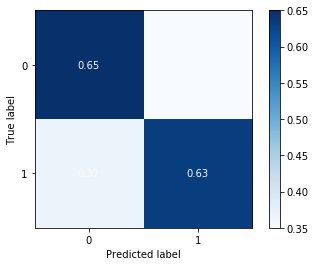

In [34]:
# display confusion matrix
disp = plot_confusion_matrix(rf2, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

## 3.2 Random Under Sampling (same process above)

In [25]:
X_train, y_train = rus.fit_resample(X_original_train, Y_original_train)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train)

In [26]:
param_test1 = {'n_estimators': range(10, 71, 10)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(min_samples_split=100,
                                                        min_samples_leaf=20,
                                                        max_depth=8,
                                                        max_features='sqrt',
                                                        random_state=10),
                       param_grid=param_test1, scoring='roc_auc', cv=5, n_jobs=4)
gsearch1.fit(Xtrain, ytrain)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.6788839497144867)

In [27]:
param_test2 = {'max_depth':range(3, 14, 2), 'min_samples_split':range(50, 201, 20)}
gsearch2 = GridSearchCV(estimator=RandomForestClassifier(n_estimators=70,
                                                        min_samples_leaf=20,
                                                        max_features='sqrt',
                                                        random_state=10,
                                                        ),
                       param_grid=param_test2, scoring='roc_auc', cv=5, n_jobs=4)
gsearch2.fit(Xtrain, ytrain)
gsearch2.best_params_, gsearch1.best_score_

({'max_depth': 13, 'min_samples_split': 150}, 0.6788839497144867)

In [29]:
param_test3 = {'min_samples_split':range(110,190,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=13,
                                  max_features='sqrt', random_state=10),
                        param_grid = param_test3, scoring='roc_auc', cv=5, n_jobs=4)
gsearch3.fit(Xtrain, ytrain)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 150}, 0.6826609159702903)

In [30]:
param_test4 = {'max_features':range(3,11,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=13, min_samples_split=150,
                                  min_samples_leaf=10, random_state=10),
   param_grid = param_test4, scoring='roc_auc', cv=5, n_jobs=4)
gsearch4.fit(Xtrain, ytrain)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 7}, 0.6826609159702903)

In [31]:
rf3 = RandomForestClassifier(n_estimators= 70, max_depth=13, min_samples_split=150,
                                  min_samples_leaf=10, max_features=7, random_state=10)
rf3.fit(Xtrain, ytrain)
rf3.score(X_test, y_test)

0.6191553544494721

In [32]:
y_pred = rf3.predict(X_test)
metrics.roc_auc_score(y_test, y_pred)

0.6505604347507316

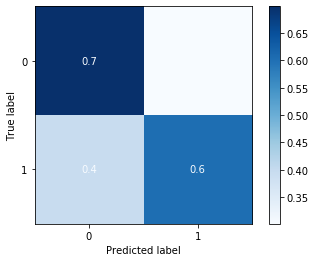

In [33]:
disp = plot_confusion_matrix(rf3, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

## 4. Ensemble Model

In [34]:
# ensemble models into list
ensemble_model = []
for i in range(11):
    X_train, y_train = rus.fit_resample(X_original_train, Y_original_train)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train)
    under_sample_model = RandomForestClassifier(n_estimators= 70,
                                                max_depth=13,
                                                min_samples_split=150,
                                                min_samples_leaf=10,
                                                max_features=7,
                                                random_state=10)
    under_sample_model.fit(Xtrain, ytrain)
    ensemble_model.append(under_sample_model)
    
    X_train, y_train = ros.fit_resample(X_original_train, Y_original_train)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train)
    over_sample_model = RandomForestClassifier(n_estimators=70,
                                               max_depth=13,
                                               min_samples_split=10,
                                               min_samples_leaf=10,
                                               max_features=9,
                                               random_state=10)
    over_sample_model.fit(Xtrain, ytrain)
    ensemble_model.append(over_sample_model)

In [35]:
# using ensemble model to predict
results = []
for model in ensemble_model:
    y_pred = model.predict(X_test)
    results.append(y_pred)

y_ensemble_result = []
for i in range(len(results[0])):
    y_single_pred = 0
    for j in range(len(results)):
        y_single_pred = y_single_pred + results[j][i]
    y_ensemble_result.append(y_single_pred > 6)
print("Acurracy: ", y_ensemble_result.count(1)/len(y_ensemble_result))

Acurracy:  0.6085972850678733


<Figure size 432x288 with 0 Axes>

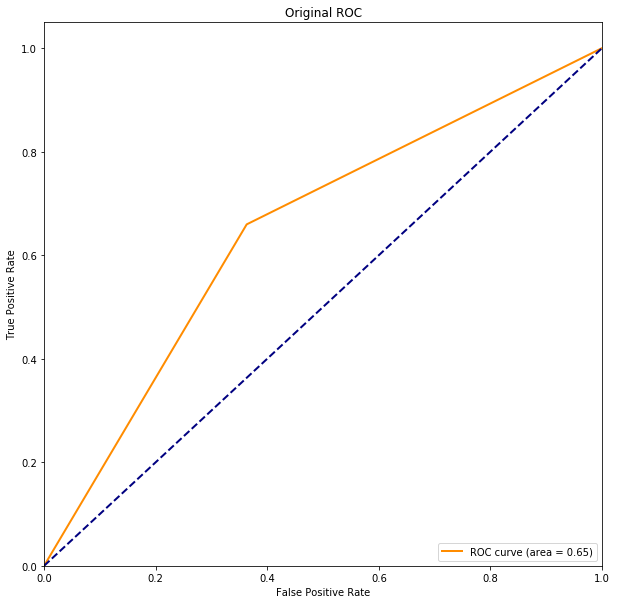

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_ensemble_result)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Original ROC')
plt.legend(loc="lower right")
plt.show()